In [1]:
#!pip install numpy==1.19.4

In [2]:
# https://www.pyimagesearch.com/2020/04/27/fine-tuning-resnet-with-keras-tensorflow-and-deep-learning/

In [3]:
# https://github.com/tensorflow/tensorflow/issues/44176

In [4]:
# https://github.com/tensorflow/tensorflow/issues/43174
from tensorflow.compat.v1 import ConfigProto, InteractiveSession, enable_eager_execution
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

enable_eager_execution()

In [6]:
from tensorflow.keras import mixed_precision

# Equivalent to the two lines above
mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce RTX 2080, compute capability 7.5


In [7]:
# import the necessary packages
# from pyimagesearch import config
import tensorflow as tf
import tensorflow.keras.layers
from tensorflow.keras.applications import ResNet50

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50

from sklearn.preprocessing import PowerTransformer, RobustScaler, QuantileTransformer, MinMaxScaler

from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

import seaborn as sns

from sklearn.utils import shuffle


import PIL

In [8]:
plt.rcParams['figure.figsize'] = 20, 10

# Getting Label Data and Image IDs

In [9]:
complete_data = pd.read_csv('../../../../WikiArt-Emotions/WikiArt-Emotions-All.tsv', sep='\t')

In [10]:
complete_data.head()

,ID,Style,Category,Artist,Title,Year,Image URL,Painting Info URL,Artist Info URL,Is painting,...,TitleOnly: love,TitleOnly: optimism,TitleOnly: pessimism,TitleOnly: regret,TitleOnly: sadness,TitleOnly: shame,TitleOnly: shyness,TitleOnly: surprise,TitleOnly: trust,TitleOnly: neutral
0,58c6237dedc2c9c7dc0de1ae,Modern Art,Impressionism,Charles Courtney Curran,In the Luxembourg Garden,1889,https://use2-uploads3.wikiart.org/00123/images...,https://www.wikiart.org/en/charles-courtney-cu...,https://www.wikiart.org/en/charles-courtney-cu...,yes,...,0.155,0.238,0.024,0.012,0.024,0.012,0.000,0.048,0.155,0.0
1,577280dfedc2cb3880f28e76,Modern Art,Neo-Expressionism,Keith Haring,The Marriage of Heaven and Hell,1984,https://use2-uploads1.wikiart.org/images/keith...,https://www.wikiart.org/en/keith-haring/the-ma...,https://www.wikiart.org/en/keith-haring,yes,...,0.200,0.000,0.100,0.000,0.000,0.000,0.000,0.200,0.000,0.0
2,57727f2dedc2cb3880ed5fa9,Modern Art,Post-Impressionism,Jozsef Rippl-Ronai,Uncle Piacsek in front of the Black Sideboard,1906,https://use2-uploads3.wikiart.org/images/j-zse...,https://www.wikiart.org/en/jozsef-rippl-ronai/...,https://www.wikiart.org/en/jozsef-rippl-ronai,yes,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.100,0.100,0.0
3,58d1240cedc2c94f900fc610,Modern Art,Cubism,Vadym Meller,Monk. For the Play &#39;Mazeppa&#39;,1920,https://use2-uploads2.wikiart.org/00124/images...,https://www.wikiart.org/en/vadym-meller/monk-f...,https://www.wikiart.org/en/vadym-meller,yes,...,0.091,0.091,0.000,0.000,0.091,0.000,0.091,0.182,0.091,0.0
4,57727de7edc2cb3880e91f26,Post Renaissance Art,Romanticism,David Wilkie,The Defence of Sarago&#231;a,1828,https://use2-uploads6.wikiart.org/images/david...,https://www.wikiart.org/en/david-wilkie/the-de...,https://www.wikiart.org/en/david-wilkie,yes,...,0.077,0.231,0.077,0.077,0.154,0.077,0.077,0.154,0.385,0.0


In [11]:
labels_cols = [col for col in complete_data.columns if 'ImageOnly:' in col]

In [12]:
id_and_labels_pd = complete_data[['ID'] + labels_cols].rename(columns=lambda x: x.replace('ImageOnly: ', '')).copy()

In [13]:
AVOID_LABELS = ['neutral','shyness','shame','ID']

In [14]:
FINAL_LABEL_COLS = [col for col in id_and_labels_pd.columns if col not in AVOID_LABELS]

In [15]:
id_and_labels_pd.head()

,ID,agreeableness,anger,anticipation,arrogance,disagreeableness,disgust,fear,gratitude,happiness,...,love,optimism,pessimism,regret,sadness,shame,shyness,surprise,trust,neutral
0,58c6237dedc2c9c7dc0de1ae,0.060,0.012,0.071,0.024,0.012,0.000,0.012,0.119,0.726,...,0.250,0.274,0.012,0.000,0.131,0.000,0.024,0.024,0.250,0.0
1,577280dfedc2cb3880f28e76,0.000,0.000,0.100,0.000,0.000,0.100,0.300,0.000,0.100,...,0.000,0.200,0.200,0.100,0.200,0.000,0.000,0.500,0.000,0.0
2,57727f2dedc2cb3880ed5fa9,0.000,0.000,0.200,0.000,0.000,0.000,0.000,0.100,0.500,...,0.000,0.300,0.000,0.000,0.000,0.000,0.000,0.100,0.200,0.0
3,58d1240cedc2c94f900fc610,0.000,0.000,0.091,0.000,0.000,0.091,0.000,0.000,0.091,...,0.000,0.000,0.182,0.000,0.364,0.000,0.000,0.273,0.000,0.0
4,57727de7edc2cb3880e91f26,0.077,0.077,0.077,0.231,0.308,0.308,0.308,0.231,0.154,...,0.077,0.231,0.231,0.077,0.231,0.154,0.077,0.154,0.231,0.0


In [16]:
id_and_labels_pd.describe().T[['mean','50%','min','max']]

,mean,50%,min,max
agreeableness,0.031336,0.000,0.0,0.400
anger,0.034361,0.000,0.0,0.727
anticipation,0.192566,0.182,0.0,0.818
arrogance,0.045590,0.000,0.0,0.800
disagreeableness,0.035555,0.000,0.0,0.700
disgust,0.069845,0.012,0.0,0.727
fear,0.109806,0.060,0.0,1.000
gratitude,0.049602,0.000,0.0,0.545
happiness,0.242745,0.182,0.0,1.000
humility,0.140305,0.100,0.0,0.800


In [87]:
len(labels_cols)

20

<AxesSubplot:>

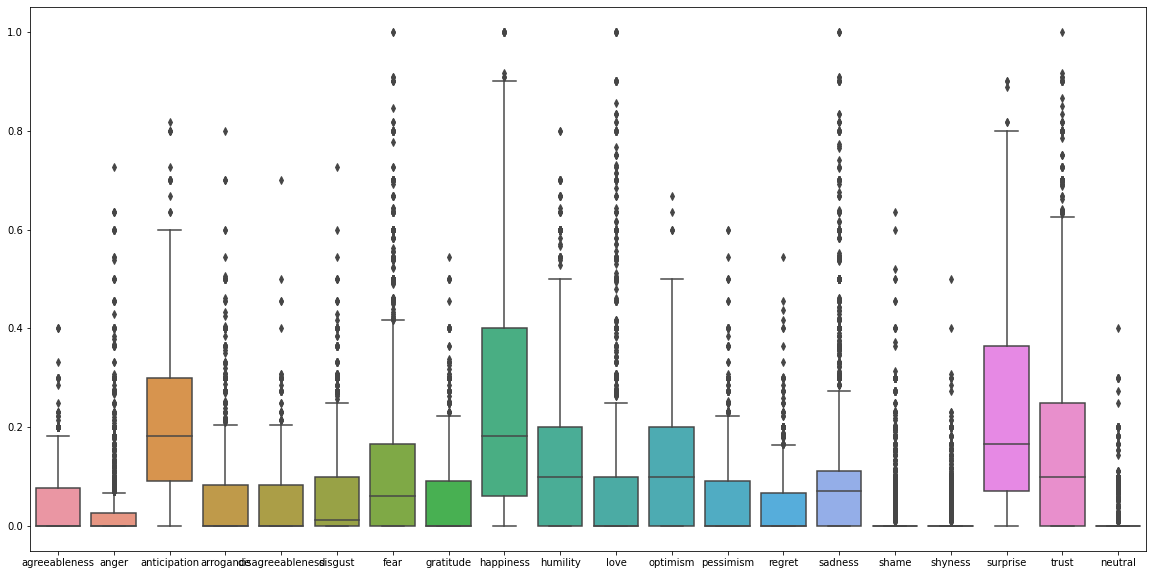

In [88]:
sns.boxplot(data=complete_data[labels_cols].rename(columns=lambda x: x.replace('ImageOnly: ', '')))

<AxesSubplot:>

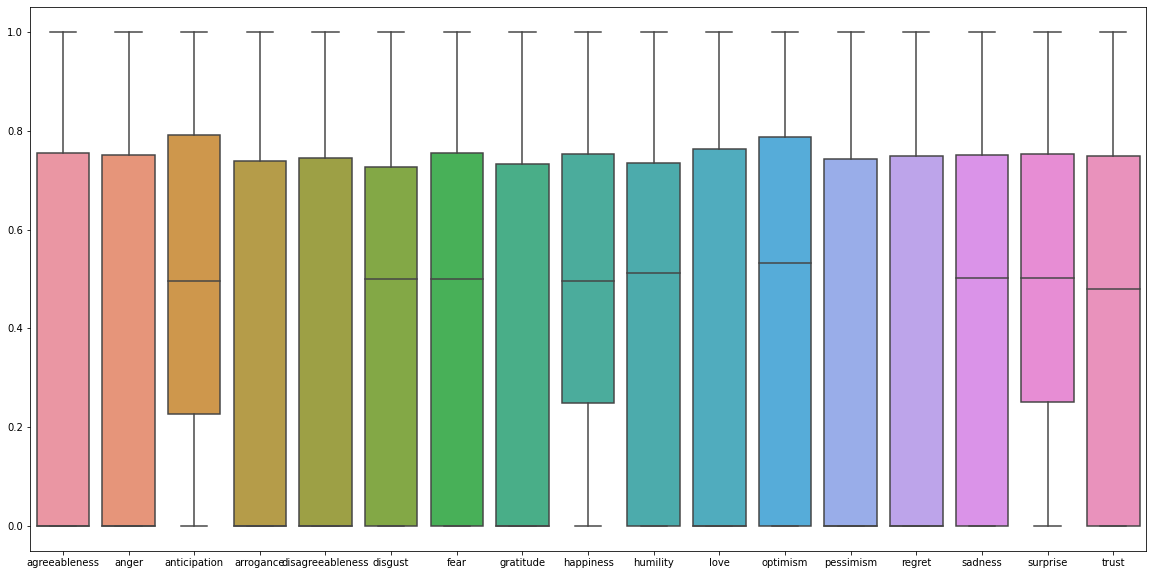

In [18]:
sns.boxplot(data=pd.DataFrame(id_and_labels_pd[FINAL_LABEL_COLS].pipe(QuantileTransformer().fit_transform), columns=FINAL_LABEL_COLS))

In [19]:
final_id_and_labels_pd = id_and_labels_pd[['ID'] + FINAL_LABEL_COLS].copy()

# Getting Images

In [20]:
def get_wikiart_img_path(img_id, root_path='../../../../WikiArt-Emotions/images', suffix='.jpg'):
    return f'{root_path}/{img_id}{suffix}'

In [21]:
test_img_path = get_wikiart_img_path('58c6237dedc2c9c7dc0de1ae')

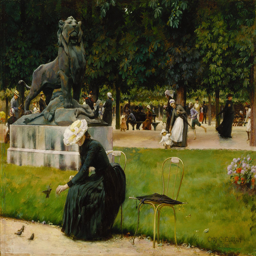

In [22]:
PIL.Image.open(test_img_path).resize((256, 256))

In [23]:
paths = list(id_and_labels_pd['ID'].apply(get_wikiart_img_path).values)

In [24]:
id_and_labels_pd['image_path'] = paths

In [25]:
id_and_labels_pd = id_and_labels_pd[id_and_labels_pd['image_path'].apply(os.path.exists)]

# Defining Preprocessing

# Splitting

In [26]:
def get_train_test_and_validation(dataframe, train_pct=0.75, val_pct=0.1, random_state=None):
    dataframe_shuffled = shuffle(dataframe, random_state=random_state).copy()
    
    train_split_idx = int(len(dataframe_shuffled) * train_pct)
    
    complete_train_df = dataframe_shuffled.iloc[:train_split_idx]
    test_df = dataframe_shuffled.iloc[train_split_idx:]
    
    val_split_idx = int(len(complete_train_df) * val_pct)
    val_df = complete_train_df.iloc[:val_split_idx]
    train_df = complete_train_df.iloc[val_split_idx:]
    
    return train_df, val_df, test_df

In [27]:
len(pd.concat(get_train_test_and_validation(id_and_labels_pd))) # it werks!

4099

In [28]:
train_df, val_df, test_df = get_train_test_and_validation(id_and_labels_pd)

In [36]:
test_map = test_df[['ID','image_path']].set_index('image_path')['ID'].to_dict()

### Preprocessing Y

In [29]:
transformer = RobustScaler()

In [30]:
#train_df[FINAL_LABEL_COLS] = transformer.fit_transform(train_df[FINAL_LABEL_COLS])
#val_df[FINAL_LABEL_COLS] = transformer.transform(val_df[FINAL_LABEL_COLS])
#test_df[FINAL_LABEL_COLS] = transformer.transform(test_df[FINAL_LABEL_COLS])

In [31]:
total_train = len(train_df)
total_test = len(test_df)
total_val = len(val_df)

In [32]:
print(len(train_df))
print(len(val_df))
print(len(test_df))

2767
307
1025


### Dataflows

In [33]:
DATA_GEN_FLOW_SIZE = (256, 256)

In [34]:
def load_resize_img(path, label, out_shape=(299, 299)):
    # path/label represent values for a single example
    image = tf.image.decode_jpeg(tf.io.read_file(path), channels=3)

    # some mapping to constant size - be careful with distorting aspec ratios
    image = tf.image.resize(image, list(out_shape))

    return image, label

def get_tf_data_generator(image_paths, labels, shuffle=False, batch_size=32, cache_location=None, target_size=(299, 299)):   
    assert len(image_paths) == len(labels)
    total_size = len(image_paths)

    tf_image_paths = tf.convert_to_tensor(image_paths, dtype=tf.string)
    tf_labels = tf.convert_to_tensor(labels)

    dataset = tf.data.Dataset.from_tensor_slices((tf_image_paths, tf_labels))
    #dataset = dataset.filter(lambda path, label: not tf.io.gfile.exists(path.numpy()))
    
    if shuffle:
        dataset = dataset.shuffle(total_size)
    
    return (dataset
        .map(lambda path, label: load_resize_img(path, label, target_size), num_parallel_calls=8)
        .cache()
        .batch(batch_size, drop_remainder=True)
        .prefetch(tf.data.AUTOTUNE)
    )

# Transfer Learning and Finetuning

https://keras.io/guides/transfer_learning/#transfer-learning-amp-finetuning-with-a-custom-training-loop

### Define model function

In [38]:
def define_transfer_learning_model(
    base_model_class=tf.keras.applications.ResNet50,
    preprocess_fn=tf.keras.applications.resnet50.preprocess_input,
    base_model_shape=(234, 234,  3)
):
    base_model = base_model_class(weights="imagenet", include_top=False)
    base_model.trainable = False # transfer_learning
        
    inputs = tf.keras.Input(shape=base_model_shape)
        
    input_data_augmentation = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.experimental.preprocessing.RandomHeight(0.1),
        tf.keras.layers.experimental.preprocessing.RandomContrast((0.0, 1)),
        tf.keras.layers.experimental.preprocessing.RandomWidth(0.1),
        tf.keras.layers.experimental.preprocessing.RandomRotation(25/360, 'nearest'),
        tf.keras.layers.experimental.preprocessing.RandomZoom(0.1, 0.1, 'nearest')
    ])
    
    x = input_data_augmentation(inputs)
    x = preprocess_fn(x)
    x = base_model(x, training=False)
    
    # construct the head of the model that will be placed on top of the
    # the base model
    head_model = tf.keras.layers.GlobalAveragePooling2D()(x)
    head_model = Dense(256, activation="relu")(head_model)
    head_model = Dropout(0.5)(head_model)

    outputs = Dense(len(FINAL_LABEL_COLS), dtype='float32', activation="softmax")(head_model)
    
    # place the head FC model on top of the base model (this will become
    # the actual model we will train)
    model = Model(inputs=inputs, outputs=outputs)
        
    return model, base_model

In [40]:
models = {
    'INCEPTION_V3': (tf.keras.applications.InceptionV3, tf.keras.applications.inception_v3.preprocess_input, (299, 299, 3))
    ,'RESNET50': (tf.keras.applications.ResNet50, tf.keras.applications.resnet50.preprocess_input, (234, 234, 3))
    ,'XCEPTION': (tf.keras.applications.Xception, tf.keras.applications.xception.preprocess_input, (299, 299, 3))
}

In [49]:
SELECTED_MODEL = 'RESNET50'

base_model_class, preprocess_fn, base_model_shape = models[SELECTED_MODEL]
target_size = base_model_shape[:2]

model, base_model = define_transfer_learning_model(base_model_class, preprocess_fn, base_model_shape)

In [50]:
tf_data_train_gen_32bs = get_tf_data_generator(train_df['image_path'].values, train_df[FINAL_LABEL_COLS].values, shuffle=True, cache_location='train_32bs', target_size=target_size, batch_size=32)
tf_data_test_gen_32bs = get_tf_data_generator(test_df['image_path'].values, test_df[FINAL_LABEL_COLS].values, cache_location='test_32bs', target_size=target_size, batch_size=32)
tf_data_val_gen_32bs = get_tf_data_generator(val_df['image_path'].values, val_df[FINAL_LABEL_COLS].values, cache_location='val_32bs', target_size=target_size, batch_size=32)

In [51]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")


### Transfer Learning Head Model

In [52]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 234, 234, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, None, None, 3)     0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, None, None, 3)     0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, None, None, 3)     0         
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               5245

In [54]:
INIT_LR = 1e-4
BS = 32
NUM_EPOCHS = 30

# compile the model
opt = Adam()

# modelamos los valores directamente, asi que mean_absolute_error (just in case por los outliers)
model.compile(loss="mean_absolute_error", optimizer=opt, metrics=["mean_absolute_error"])

# train the model
H = model.fit(
    tf_data_train_gen_32bs,
    #batch_size=32,
    #steps_per_epoch=total_train // BS,
    validation_data=tf_data_val_gen_32bs,
    #validation_steps=total_val // BS,
    epochs=NUM_EPOCHS,
    callbacks=[tensorboard_callback],
)

Epoch 1/30
86/86 [==============================] - 7s 63ms/step - loss: 0.0725 - mean_absolute_error: 0.0725 - val_loss: 0.0738 - val_mean_absolute_error: 0.0738
Epoch 2/30
86/86 [==============================] - 5s 53ms/step - loss: 0.0723 - mean_absolute_error: 0.0723 - val_loss: 0.0728 - val_mean_absolute_error: 0.0728
Epoch 3/30
86/86 [==============================] - 5s 54ms/step - loss: 0.0714 - mean_absolute_error: 0.0714 - val_loss: 0.0724 - val_mean_absolute_error: 0.0724
Epoch 4/30
86/86 [==============================] - 5s 56ms/step - loss: 0.0717 - mean_absolute_error: 0.0717 - val_loss: 0.0726 - val_mean_absolute_error: 0.0726
Epoch 5/30
86/86 [==============================] - 5s 54ms/step - loss: 0.0715 - mean_absolute_error: 0.0715 - val_loss: 0.0731 - val_mean_absolute_error: 0.0731
Epoch 6/30
86/86 [==============================] - 5s 54ms/step - loss: 0.0712 - mean_absolute_error: 0.0712 - val_loss: 0.0724 - val_mean_absolute_error: 0.0724
Epoch 7/30
86/86 [====

KeyboardInterrupt: 

### Fine-tuning base model

In [55]:
base_model.trainable = True
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 234, 234, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, None, None, 3)     0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, None, None, 3)     0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, None, None, 3)     0         
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               5245

In [56]:
model.compile(
    optimizer=Adam(1e-5),  # Low learning rate
    loss="mean_absolute_error",
    metrics=["mean_absolute_error"],
)

H2 = model.fit(
    tf_data_train_gen_32bs,
    #batch_size=BS,
    validation_data=tf_data_val_gen_32bs,
    epochs=NUM_EPOCHS,
    callbacks=[tensorboard_callback]
)

Epoch 1/30
86/86 [==============================] - 71s 768ms/step - loss: 0.0700 - mean_absolute_error: 0.0700 - val_loss: 0.0724 - val_mean_absolute_error: 0.0724
Epoch 2/30
86/86 [==============================] - 34s 396ms/step - loss: 0.0690 - mean_absolute_error: 0.0690 - val_loss: 0.0720 - val_mean_absolute_error: 0.0720
Epoch 3/30
86/86 [==============================] - 23s 266ms/step - loss: 0.0687 - mean_absolute_error: 0.0687 - val_loss: 0.0719 - val_mean_absolute_error: 0.0719
Epoch 4/30
86/86 [==============================] - 22s 253ms/step - loss: 0.0681 - mean_absolute_error: 0.0681 - val_loss: 0.0720 - val_mean_absolute_error: 0.0720
Epoch 5/30
86/86 [==============================] - 16s 191ms/step - loss: 0.0682 - mean_absolute_error: 0.0682 - val_loss: 0.0730 - val_mean_absolute_error: 0.0730
Epoch 6/30
86/86 [==============================] - 13s 148ms/step - loss: 0.0676 - mean_absolute_error: 0.0676 - val_loss: 0.0723 - val_mean_absolute_error: 0.0723
Epoch 7/30

KeyboardInterrupt: 

In [252]:
NEW_BS = 128

model.compile(
    optimizer=Adam(1e-5),  # Low learning rate
    loss="mean_absolute_error",
    metrics=["mean_absolute_error"],
)

H2 = model.fit_generator(
    train_generator,
    #batch_size=BS,
    steps_per_epoch=total_train // NEW_BS,
    validation_data=val_generator,
    validation_steps=total_val // NEW_BS,
    epochs=NUM_EPOCHS,
    callbacks=[tensorboard_callback]
)

/home/goviedb/python_venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
21/21 [==============================] - ETA: 0s - loss: 0.0980 - mean_absolute_error: 0.0980

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f2c66f01f70>
Traceback (most recent call last):
  File "/home/goviedb/python_venv/lib/python3.8/site-packages/tensorflow/python/data/ops/iterator_ops.py", line 534, in __del__
    gen_dataset_ops.delete_iterator(
  File "/home/goviedb/python_venv/lib/python3.8/site-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1263, in delete_iterator
    _result = pywrap_tfe.TFE_Py_FastPathExecute(
KeyboardInterrupt: 


21/21 [==============================] - 11s 457ms/step - loss: 0.0980 - mean_absolute_error: 0.0980 - val_loss: 0.1011 - val_mean_absolute_error: 0.1011
Epoch 2/10
 6/21 [=======>......................] - ETA: 6s - loss: 0.1013 - mean_absolute_error: 0.1013

KeyboardInterrupt: 

In [58]:
model.evaluate_generator(tf_data_test_gen_32bs)

/home/goviedb/python_venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.07543855160474777, 0.07543855160474777]

In [59]:
test_predict = model.predict_generator(tf_data_test_gen_32bs)

/home/goviedb/python_venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [60]:
pd_test_predict = pd.DataFrame(test_predict, columns=FINAL_LABEL_COLS)

In [66]:
pd_test_predict['image_path'] = test_df['image_path'].reset_index(drop=True)

In [67]:
pd_test_predict['ID'] = pd_test_predict['image_path'].map(test_map)

In [68]:
FINAL_LABEL_COLS

['agreeableness',
 'anger',
 'anticipation',
 'arrogance',
 'disagreeableness',
 'disgust',
 'fear',
 'gratitude',
 'happiness',
 'humility',
 'love',
 'optimism',
 'pessimism',
 'regret',
 'sadness',
 'surprise',
 'trust']

In [75]:
emotion_to_check = 'happiness'
pd_test_predict.sort_values(by=emotion_to_check)[['image_path',emotion_to_check]]

,image_path,happiness
107,../../../../WikiArt-Emotions/images/577283d7ed...,0.000128
520,../../../../WikiArt-Emotions/images/5772874ced...,0.000175
704,../../../../WikiArt-Emotions/images/577270e8ed...,0.000229
91,../../../../WikiArt-Emotions/images/5772845aed...,0.000420
848,../../../../WikiArt-Emotions/images/5772804ded...,0.000479
...,...,...
482,../../../../WikiArt-Emotions/images/577276f1ed...,0.593678
772,../../../../WikiArt-Emotions/images/57727da7ed...,0.621741
294,../../../../WikiArt-Emotions/images/57726e49ed...,0.627356
791,../../../../WikiArt-Emotions/images/57728400ed...,0.629896


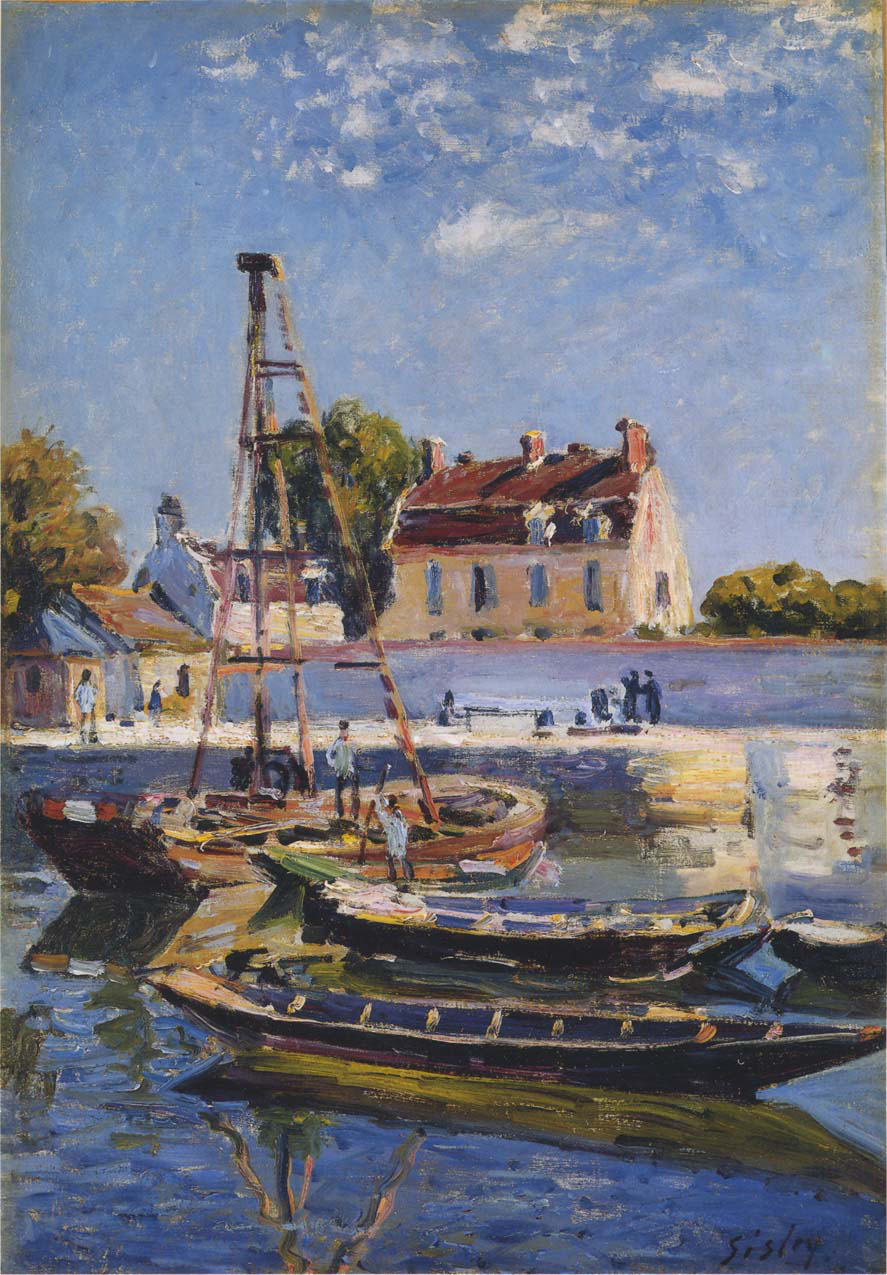

In [82]:
file_path_to_check = pd_test_predict.sort_values(by=emotion_to_check)[['image_path',emotion_to_check]].iloc[-5]['image_path']
PIL.Image.open(file_path_to_check)

# Applying to new data

In [ ]:
new_data_augmentation = ImageDataGenerator()


In [31]:
#model.save('experiment_2.pkl')

INFO:tensorflow:Assets written to: experiment_1.pkl/assets
